# **Seattle Terry Stop Data Analysis**

##### Author: Spencer Hadel
***
### Overview

Recent tensions in the United States have led to a mistrust of police forces across the country, particularly due to the increasing strength of movements such as Black Lives Matter, and increased cultural attention to the racial and ethnic disparity in many facets of life. There is increasing focus on the scope of what police officer's are legally able to do, and whether they use this right fairly.

One such disparity has been observed in Terry Stops (also known as 'stop-and-frisks'), when a police officer uses theur right to legally temporarily detain a person based on 'reasonable suspsicion' that the person may be involved in criminal activity. The officer has the right to physically 'frisk' the subject, and take whatever action they feel is necessary properly handle the situation.

The newly elected mayor of Seattle campaigned on a platform of police reform, and has hired our agency to analyze, test, and interpret the current Seattle police department's Terry Stop data, so that their selected Chief of Police can make meaningful changes to the system as it stands.


### Data
This analysis utilizes about 52,000 data entries of Seattly Terry Stops ([from data.seattle.gov](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8)), in the file [Terry_Stops.csv](./data/Terry_Stops.csv). This data has been collected from 2015 until the present. A deeper explanation of this dataset and how it was cleaned can be found in the [Previous Notebook](./nb_1-terry_data_cleaning_analysis.ipynb).

***


# Part 2: Classification Models
Now we will attempt to create classiffication Models that can accurately predict the outcomes of Terry Stops Based on the data as recorded by Seattle.gov

In [1]:
from imports import *

In [2]:
#load data
df = pd.read_csv('data/cleaned_df.csv')

#look at current features of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52147 non-null  object
 1   Was_Weapon_Reported       52147 non-null  object
 2   Officer_Gender            52147 non-null  object
 3   Officer_Race              52147 non-null  object
 4   Subject_Perceived_Race    52147 non-null  object
 5   Subject_Perceived_Gender  52147 non-null  object
 6   Frisk_Flag                52147 non-null  int64 
 7   Officer_Age               52147 non-null  int64 
 8   Legal_Action_Taken        52147 non-null  int64 
 9   Arrested                  52147 non-null  int64 
 10  Physical_Arrest           52147 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 4.4+ MB


## Target: Physical Arrest

First we attempt to create a classifier that can determine whether legal action was taken. So we will remove the other target variables entirely.

In [3]:
#other target variables are likely to heavily overlap with current target,
#so should be removed to prevent models from being mistrained on this data
df.drop(['Arrested', 'Legal_Action_Taken'], axis=1, inplace=True)

#set negative and positive variables for score output later
neg = 'No Physical Arrest'
pos = 'Physical Arrest'

### Categorical Variables
Next the non-numeric variables need to be split into data types that can be properly interpreted by our classifiers.


In [4]:
#creating dummy features in the place of categorical features
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.columns = dummies_df.columns.str.replace(' ','_')

#observe new dataset
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 27 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Frisk_Flag                                                        52147 non-null  int64
 1   Officer_Age                                                       52147 non-null  int64
 2   Physical_Arrest                                                   52147 non-null  int64
 3   Subject_Age_Group_1_-_17                                          52147 non-null  uint8
 4   Subject_Age_Group_18_-_25                                         52147 non-null  uint8
 5   Subject_Age_Group_26_-_35                                         52147 non-null  uint8
 6   Subject_Age_Group_36_-_45                                         52147 non-null  uint8
 7   Subject_Age_Group_46_-_55                        

### Splitting Data

Now we separate the data into train and test sets, and scale the features so that our algorithms can properly interpret them.

In [5]:
#separate target from features, and split all data into training and testing sets
X= dummies_df.drop('Physical_Arrest', axis=1)
y = dummies_df['Physical_Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Choosing Evaluation Metric Functions

We want to focus on the Precision and Recall, and by extension the F1 score because we want to avoid both false positives and false negatives in our evaluation.

Accuracy alone would not be a good metric as our data contains an imbalance in target variables, and a model predicting "No Action Taken" stands a good chance to be accurate in most cases. 

We will also create confusion matrices to see the exact distributions of True Positives, False Positives, True Negatives, and False Negatives. In addition, we will display the classification report for each model, and discuss the performance of each model according to the scores.


The code that shows us these scores can be found in [functions.py](./functions.py)


In [6]:
#create dataframe for storing scores
score_df = pd.DataFrame(columns = ['Name','Accuracy', 'Recall', 'Precision', 'F1'])

### Baseline Model

We start with a baseline Logistic Regression Model.

In [7]:
#create logistic regression model using training data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

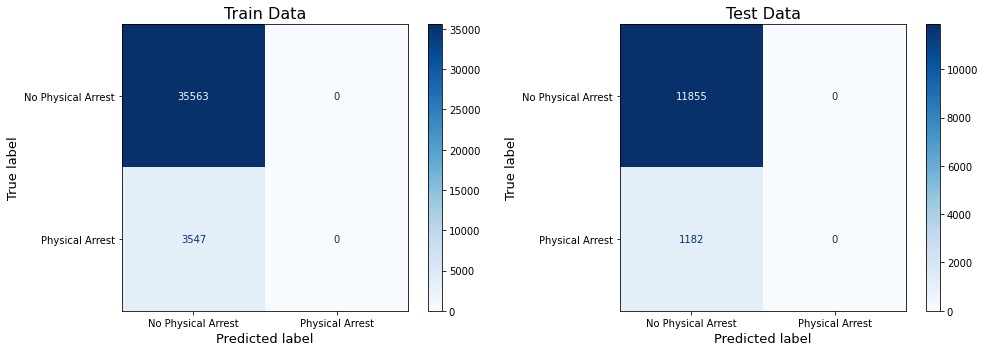

Train Data:                                 Test Data:
Accuracy:  0.9093070825875735               Accuracy:  0.9093349697016184
Recall:    0.0                              Recall:    0.0       
Precision: 0.0                              Precision: 0.0       
F1:        0.0                              F1:        0.0       

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.91      1.00      0.95     11855
   Physical Arrest       0.00      0.00      0.00      1182

          accuracy                           0.91     13037
         macro avg       0.45      0.50      0.48     13037
      weighted avg       0.83      0.91      0.87     13037

adding:  {'Name': 'logreg', 'Accuracy': 0.9093349697016184, 'Recall': 0.0, 'Precision': 0.0, 'F1': 0.0}


In [8]:
#show scores
clf_scores(logreg,X_train, X_test, y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(logreg, X_test, y_test, score_df, 'logreg')
#score_df.head()

### Scoring 
The confusion matrices and classification report above indicate how our model performed. In this case, it performed very poorly. The only non zero scores in the Train and Test data are Accuracy, which is only the case because such a large amount of our outcomtes are 0, indication No Physical Arrest. Therefore the model fails to successfully predict even one instance where a physical arrest is made. This is the 

The Classification Report only emphasizes this discrepancy. The model scores incredibly highly on predictions of No Physical Arrest, because that is the only thing the model predicts.

### Class Imbalance
The current assortment of target values is highly imbalanced; so we will also use SMOTE to create synthetic data based on the existing, and see if this can improve our scores.

In [9]:
# Observe current balance of target variable in train and test data

print(y_train.value_counts())
print(y_test.value_counts())

0    35563
1     3547
Name: Physical_Arrest, dtype: int64
0    11855
1     1182
Name: Physical_Arrest, dtype: int64


In [10]:
#use SMOTE to add synthetic data
# - ONLY TO TRAINING DATA, we do not want to allow this adjustment to affect our test data
smote = SMOTE(random_state = 42)
X_train_synth, y_train_synth = smote.fit_resample(X_train, y_train)

#observe new synthetic targer data balance
print(y_train_synth.value_counts())

1    35563
0    35563
Name: Physical_Arrest, dtype: int64


Now the dataset has an even balance of 1 and 0 targets, so we create a new Logistic Regression Model, in the hopes that it will this time successfully be trained to predict at least some outcomes of Physical Arrest on the test data.

In [11]:
#create new model using synthetic data

logreg_synth = LogisticRegression(max_iter=1000)
logreg_synth.fit(X_train_synth, y_train_synth)

LogisticRegression(max_iter=1000)

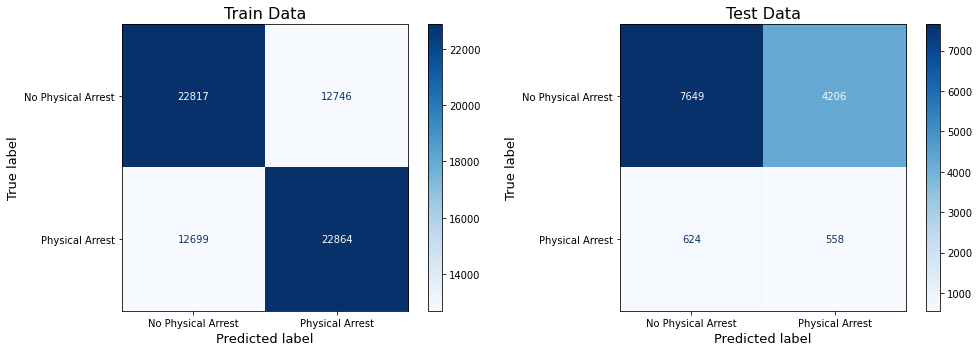

Train Data:                                 Test Data:
Accuracy:  0.6422545904451256               Accuracy:  0.6295159929431617
Recall:    0.6429153895903045               Recall:    0.4720812182741117
Precision: 0.6420668351586633               Precision: 0.11712846347607053
F1:        0.642490832197603                F1:        0.1876892028254289

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.92      0.65      0.76     11855
   Physical Arrest       0.12      0.47      0.19      1182

          accuracy                           0.63     13037
         macro avg       0.52      0.56      0.47     13037
      weighted avg       0.85      0.63      0.71     13037

adding:  {'Name': 'logreg_synth', 'Accuracy': 0.6295159929431617, 'Recall': 0.4720812182741117, 'Precision': 0.11712846347607053, 'F1': 0.1876892028254289}


In [12]:
clf_scores(logreg_synth, X_train_synth, X_test, y_train_synth, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(logreg_synth, X_test, y_test, score_df, 'logreg_synth')
#score_df.head()

### SMOTE effects 
The usage of SMOTE to create synthetic data had several notable effects. Most importantly, this new model now predicts 'Physical Arrest's at least some of the time. The model isn't very accurate, and it performs far better on the training data than on the testing data. This is often a clear sign of overfitting to the training data, but in this case is most likely caused by the severe imbalance of data pre-SMOTE.

Another cause for concern in the current model is the low precision score, a.k.a. the model's inability to predict positive cases successfully. The confusion matrix for the Test Data shows this clearly, as the mdoel predicted Physical Arrest correctly 558 times, but *incorrectly* predicted Physical Arrest 4,206 times. This is why the precision score on the model is a miniscule 0.117.

If we want to confidently claim the ability to create a model which can predict Terry Stop outcomes, we need to minimize instances where the model incorrect predicts a Physical Arrest.

## Comparing Classifiers
Now we will run through various other classifiers. We will first observe the performance of each classifier with its baseline paramters, and choose the appropriate model to explore further.

We will test KNN, Random Forest, and XGBoost.

### K Nearest Neighbors
KNN needs our data to be scaled with StandardScaler in order to function appropriately.

In [13]:
#using Standard Scaler to change ONLY the X data, as the target does not need to be scaled

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#create knn classifier, fit to data (make sure to use scaled X_train

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

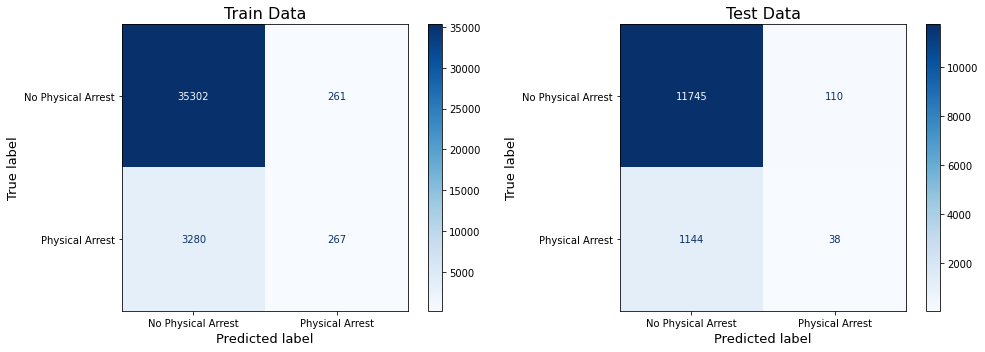

Train Data:                                 Test Data:
Accuracy:  0.9094604960368192               Accuracy:  0.9038122267392805
Recall:    0.07527488018043417              Recall:    0.032148900169204735
Precision: 0.5056818181818182               Precision: 0.25675675675675674
F1:        0.13104294478527606              F1:        0.057142857142857134

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.91      0.99      0.95     11855
   Physical Arrest       0.26      0.03      0.06      1182

          accuracy                           0.90     13037
         macro avg       0.58      0.51      0.50     13037
      weighted avg       0.85      0.90      0.87     13037

adding:  {'Name': 'knn', 'Accuracy': 0.9038122267392805, 'Recall': 0.032148900169204735, 'Precision': 0.25675675675675674, 'F1': 0.057142857142857134}


In [14]:
clf_scores(knn, X_train_scaled, X_test_scaled,y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(knn, X_test_scaled, y_test, score_df, 'knn')
#score_df.head()

In [15]:
#same steps as previous, but use synthetic training data instead

#scale synthetic data
X_train_synth_scaled = scaler.fit_transform(X_train_synth)

knn_synth = KNeighborsClassifier()
knn_synth.fit(X_train_synth_scaled, y_train_synth)

KNeighborsClassifier()

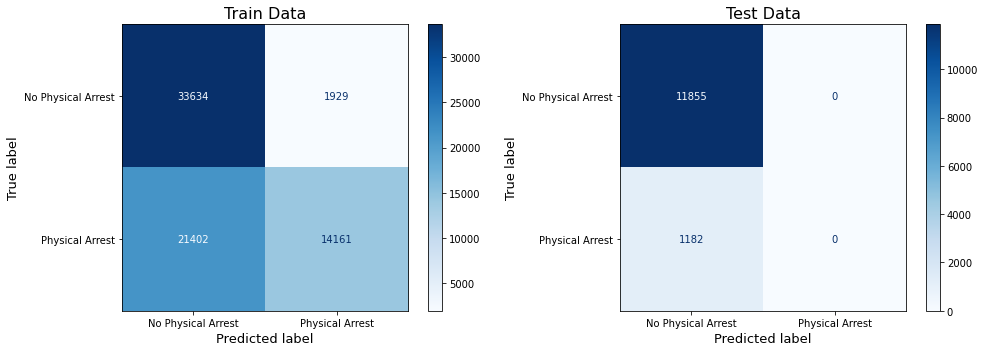

Train Data:                                 Test Data:
Accuracy:  0.6719764924218992               Accuracy:  0.9093349697016184
Recall:    0.39819475297359613              Recall:    0.0       
Precision: 0.8801118707271597               Precision: 0.0       
F1:        0.5483127795094186               F1:        0.0       

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.91      1.00      0.95     11855
   Physical Arrest       0.00      0.00      0.00      1182

          accuracy                           0.91     13037
         macro avg       0.45      0.50      0.48     13037
      weighted avg       0.83      0.91      0.87     13037

adding:  {'Name': 'knn_synth', 'Accuracy': 0.8420648922298075, 'Recall': 0.11928934010152284, 'Precision': 0.12165660051768766, 'F1': 0.1204613413071337}


In [16]:
clf_scores(knn_synth, X_train_synth_scaled, X_test, y_train_synth, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(knn_synth, X_test_scaled, y_test, score_df, 'knn_synth')
#score_df.head()

#### Performance:
K Nearest Neighbors only reduced our performance. With synthetic data it became just as ineffective at predicting outcomes as the baseline Logistic Regression model, and even without synthetic data the F1 score was only 0.05 on the test data. This is most likely because of the general lack of numerical data in the features, and the ever present class imbalance of the target variable.

Going forward, we will exclude KNN from our tests for this data.

### Random Forest

In [17]:
#create random forest classifier, fit to data

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

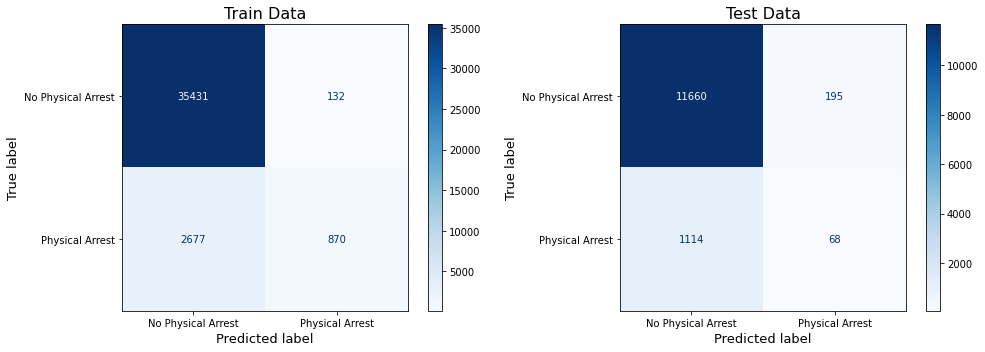

Train Data:                                 Test Data:
Accuracy:  0.9281769368447967               Accuracy:  0.8995934647541612
Recall:    0.24527769946433606              Recall:    0.05752961082910321
Precision: 0.8682634730538922               Precision: 0.2585551330798479
F1:        0.38250164871400305              F1:        0.09411764705882351

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.91      0.98      0.95     11855
   Physical Arrest       0.26      0.06      0.09      1182

          accuracy                           0.90     13037
         macro avg       0.59      0.52      0.52     13037
      weighted avg       0.85      0.90      0.87     13037

adding:  {'Name': 'forest', 'Accuracy': 0.8995934647541612, 'Recall': 0.05752961082910321, 'Precision': 0.2585551330798479, 'F1': 0.09411764705882351}


In [18]:
clf_scores(forest,X_train, X_test,y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(forest, X_test, y_test, score_df, 'forest')
#score_df.head()

In [19]:
#new random forest classifier using synthetic data

forest_synth = RandomForestClassifier(random_state=42)
forest_synth.fit(X_train_synth, y_train_synth)

RandomForestClassifier(random_state=42)

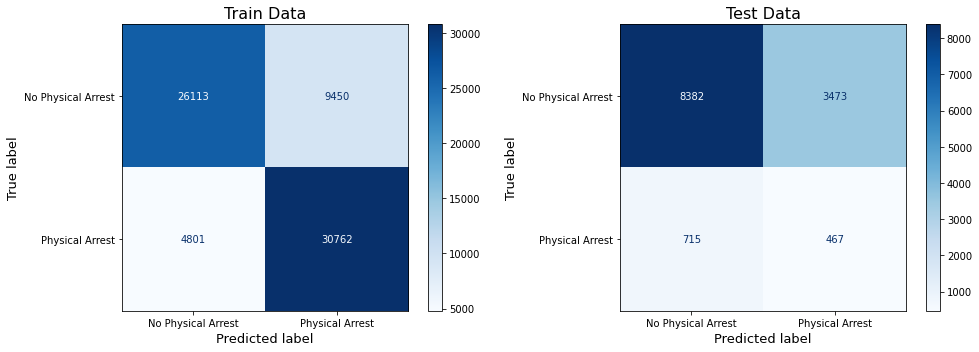

Train Data:                                 Test Data:
Accuracy:  0.7996372634479656               Accuracy:  0.6787604510240086
Recall:    0.8650001405955628               Recall:    0.39509306260575294
Precision: 0.7649955237242614               Precision: 0.11852791878172589
F1:        0.8119300560871                  F1:        0.1823506442795783

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.92      0.71      0.80     11855
   Physical Arrest       0.12      0.40      0.18      1182

          accuracy                           0.68     13037
         macro avg       0.52      0.55      0.49     13037
      weighted avg       0.85      0.68      0.74     13037

adding:  {'Name': 'forest_synth', 'Accuracy': 0.6787604510240086, 'Recall': 0.39509306260575294, 'Precision': 0.11852791878172589, 'F1': 0.1823506442795783}


In [20]:
clf_scores(forest_synth, X_train_synth, X_test, y_train_synth, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(forest_synth, X_test, y_test, score_df, 'forest_synth')
#score_df.head()

#### Performance: 
Using synthetic data, Random Forests performed similarly to our Logistic Regression model. The Classification report shows a slight improvement in the average Recall and F1 Scores, but there is still the same issue of many instances of false predictions of arrest, as well as significant differences between train and test scoring.

### XGBoost

In [21]:
#xg boost classifier, fit to data

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

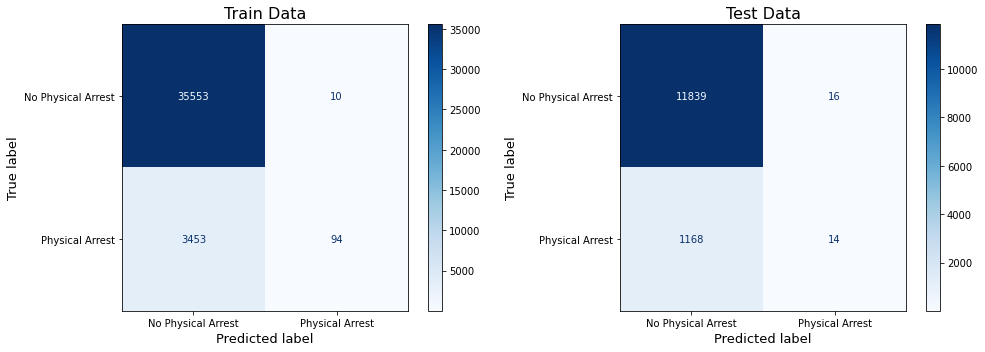

Train Data:                                 Test Data:
Accuracy:  0.9114548708770136               Accuracy:  0.9091815601748868
Recall:    0.02650126867775585              Recall:    0.011844331641285956
Precision: 0.9038461538461539               Precision: 0.4666666666666667
F1:        0.051492741714598736             F1:        0.0231023102310231

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.91      1.00      0.95     11855
   Physical Arrest       0.47      0.01      0.02      1182

          accuracy                           0.91     13037
         macro avg       0.69      0.51      0.49     13037
      weighted avg       0.87      0.91      0.87     13037

adding:  {'Name': 'xgb', 'Accuracy': 0.9091815601748868, 'Recall': 0.011844331641285956, 'Precision': 0.4666666666666667, 'F1': 0.0231023102310231}


In [22]:
clf_scores(xgb, X_train, X_test,y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(xgb, X_test, y_test, score_df, 'xgb')
#score_df.head()

In [23]:
#xg boost classifier again, this time with synthetic data

xgb_synth = XGBClassifier(random_state=42)
xgb_synth.fit(X_train_synth, y_train_synth)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

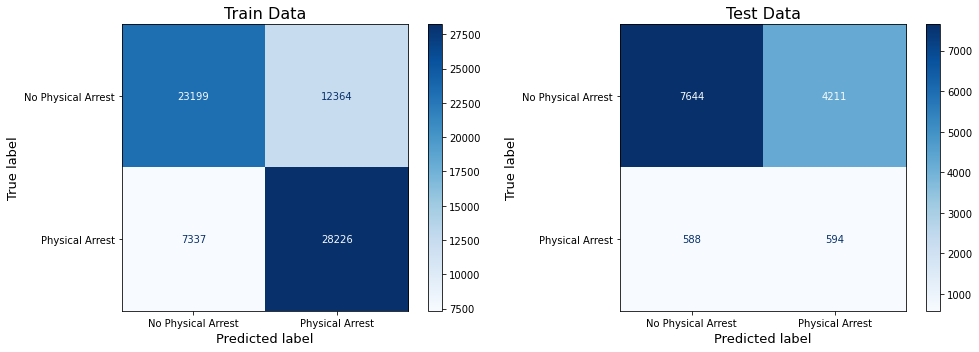

Train Data:                                 Test Data:
Accuracy:  0.723012681719765                Accuracy:  0.6318938406075018
Recall:    0.7936900711413548               Recall:    0.5025380710659898
Precision: 0.6953929539295393               Precision: 0.12362122788761706
F1:        0.7412971255236169               F1:        0.1984299315182896

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.93      0.64      0.76     11855
   Physical Arrest       0.12      0.50      0.20      1182

          accuracy                           0.63     13037
         macro avg       0.53      0.57      0.48     13037
      weighted avg       0.86      0.63      0.71     13037

adding:  {'Name': 'xgb_synth', 'Accuracy': 0.6318938406075018, 'Recall': 0.5025380710659898, 'Precision': 0.12362122788761706, 'F1': 0.1984299315182896}


In [24]:
clf_scores(xgb_synth, X_train_synth, X_test, y_train_synth, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(xgb_synth, X_test, y_test, score_df, 'xgb_synth')
#score_df.head()

#### Performance: 
Once again, our model is still not performing ideally on test data, and has far too low of a precision score (too many False Positives). Technically, the F1 score on testing data increased with XG Boost using synthetic data, but only from 0.187 to 0.198.

## Tuning Parameters
It is becoming clear with each test that our current dataset is not likely to yield the results we are hoping to, as the highest F1 score (that of XG Boost with SMOTE) does not go any higher than 0.917, when we are aiming to get as close to 1 as possible.

However, it is apparent using SMOTE will increase F1 scores, usually (as expected) at the cost of Accuracy and Precision scores. Because of this, we will use the synthetic dataset when tuning hyperparameters.

In [25]:
X_train = X_train_synth
y_train = y_train_synth

#print(y_train.value_counts())

The final step that can be attempted with the current set of features is to tune individual classifiers' hyperparameters. We will use GridSearchCV to perform an exhaustive search of some of the most common parameters to test the Logistic Regression, Random Forest, and XG Boost classifiers. 

### Logistic Regression

In [26]:
#logreg tuning

logreg = LogisticRegression(random_state=42)

#common logistic regression hyperparamaters for tuning:
logreg_param_grid = {'penalty' : ['l1', 'l2'],
                     'C' : np.logspace(-2, 2, 10),
                     'solver' :  ['liblinear']}

#create gridsearch with 'scoring = f1' so that we optimize the model to high f1 scores
logreg_cv = GridSearchCV(logreg, logreg_param_grid, cv=3,scoring='f1', verbose = True, n_jobs = -1)

#fit the model to training data
logreg_cv.fit(X_train, y_train)

#best parameters, to see which items from gridsearch were chosen for this model
logreg_cv.best_params_
#{'C': 0.027825594022071243, 'penalty': 'l1', 'solver': 'liblinear'}

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'C': 0.027825594022071243, 'penalty': 'l1', 'solver': 'liblinear'}

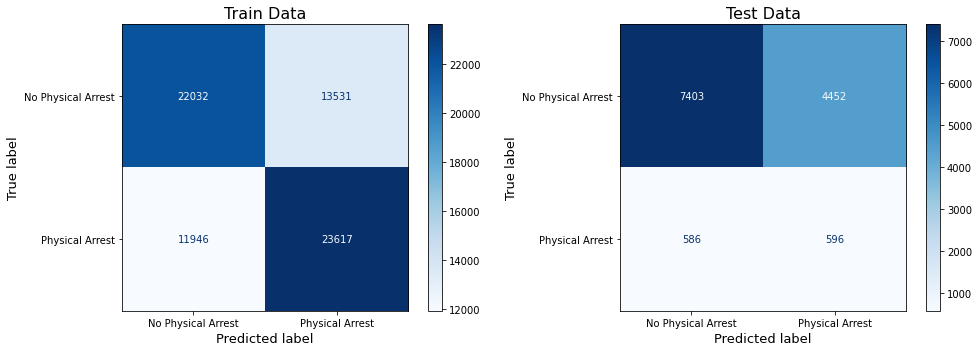

Train Data:                                 Test Data:
Accuracy:  0.6418046846441526               Accuracy:  0.6135614021630743
Recall:    0.6640890813485927               Recall:    0.5042301184433164
Precision: 0.635754280176591                Precision: 0.11806656101426308
F1:        0.6496128508753835               F1:        0.19133226324237562

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.93      0.62      0.75     11855
   Physical Arrest       0.12      0.50      0.19      1182

          accuracy                           0.61     13037
         macro avg       0.52      0.56      0.47     13037
      weighted avg       0.85      0.61      0.70     13037

adding:  {'Name': 'logreg_cv', 'Accuracy': 0.6135614021630743, 'Recall': 0.5042301184433164, 'Precision': 0.11806656101426308, 'F1': 0.19133226324237562}


In [27]:
clf_scores(logreg_cv, X_train, X_test,y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(logreg_cv, X_test, y_test, score_df, 'logreg_cv')
#score_df.head()

### Random Forest

In [28]:
#forest tuning

forest = RandomForestClassifier(random_state=42)

#common random forest hyperparamaters for tuning:
forest_param_grid = {'max_depth' : [None, 3, 4],
                    'max_features' :  ['sqrt', 'log2', 2, 5, 10],
                    'n_estimators' : [10,100,1000]}

#create gridsearch with 'scoring = f1' so that we optimize the model to high f1 scores
forest_cv = GridSearchCV(forest, forest_param_grid, scoring='f1', cv=3,verbose = True, n_jobs = -1)

#fit the model to training data
forest_cv.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4],
                         'max_features': ['sqrt', 'log2', 2, 5, 10],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1', verbose=True)

In [29]:
#best parameters, to see which items from gridsearch were chosen for this model
forest_cv.best_params_
#{'max_depth': None, 'max_features': 10, 'n_estimators': 1000}

{'max_depth': None, 'max_features': 10, 'n_estimators': 1000}

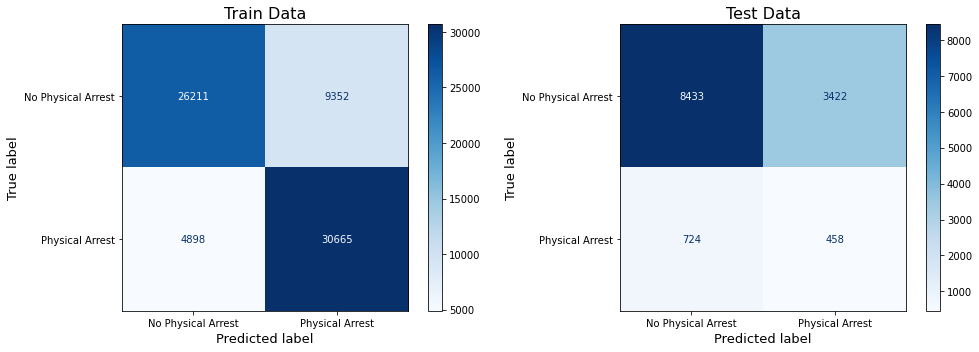

Train Data:                                 Test Data:
Accuracy:  0.799651323004246                Accuracy:  0.6819820510853724
Recall:    0.8622725866771644               Recall:    0.38747884940778343
Precision: 0.7662993227878152               Precision: 0.11804123711340206
F1:        0.8114580576872188               F1:        0.18095614381667324

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.92      0.71      0.80     11855
   Physical Arrest       0.12      0.39      0.18      1182

          accuracy                           0.68     13037
         macro avg       0.52      0.55      0.49     13037
      weighted avg       0.85      0.68      0.75     13037

adding:  {'Name': 'forest_cv', 'Accuracy': 0.6819820510853724, 'Recall': 0.38747884940778343, 'Precision': 0.11804123711340206, 'F1': 0.18095614381667324}


In [30]:
clf_scores(forest_cv, X_train, X_test,y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(forest_cv, X_test, y_test, score_df, 'forest_cv')
#score_df.head()

### XGBoost

In [31]:
#tuning (some) xg boost params, split to reduce cpu strain

xgb = XGBClassifier(random_state=42)

#common xg boost hyperparamaters for tuning:
xgb_param_grid = {'n_estimators' : [10, 100, 1000],
                  'learning_rate' : [0.001, 0.01, 0.1]}

#create gridsearch with 'scoring = f1' so that we optimize the model to high f1 scores
xgb_cv = GridSearchCV(xgb, xgb_param_grid, cv=3,scoring='f1', verbose = True, n_jobs = -1)

#fit the model to training data
xgb_cv.fit(X_train, y_train)

#best parameters, to see which items from gridsearch were chosen for this model
xgb_cv.best_params_
#{'learning_rate': 0.1,'n_estimators': 1000}, 
#next cell tests other params

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'learning_rate': 0.1, 'n_estimators': 1000}

In [32]:
#more tuning with results from previous

#common xg boost hyperparamaters for tuning:
xgb_param_grid = {'n_estimators' : [1000],
                  'learning_rate' : [0.1],
                  'subsample' :  np.linspace(0.1, 1, 4),
                  'max_depth' : [3, 7, 9]}

#create gridsearch with 'scoring = f1' so that we optimize the model to high f1 scores
xgb_cv = GridSearchCV(xgb, xgb_param_grid, cv=3,scoring='f1', verbose = True, n_jobs = -1)

#fit the model to training data
xgb_cv.fit(X_train, y_train)

#best parameters, to see which items from gridsearch were chosen for this model
xgb_cv.best_params_
#{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.7}

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.7}

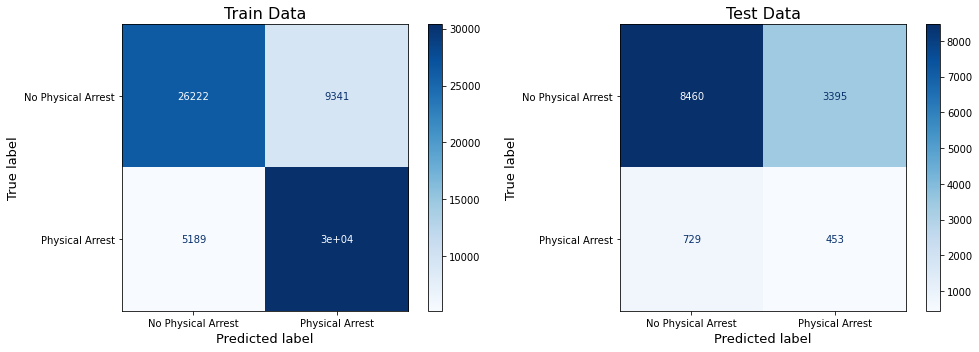

Train Data:                                 Test Data:
Accuracy:  0.7957146472457329               Accuracy:  0.6836695558794201
Recall:    0.8540899249219694               Recall:    0.383248730964467
Precision: 0.764799194259096                Precision: 0.11772349272349272
F1:        0.806982119609979                F1:        0.1801192842942346

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

No Physical Arrest       0.92      0.71      0.80     11855
   Physical Arrest       0.12      0.38      0.18      1182

          accuracy                           0.68     13037
         macro avg       0.52      0.55      0.49     13037
      weighted avg       0.85      0.68      0.75     13037

adding:  {'Name': 'xgb_cv', 'Accuracy': 0.6836695558794201, 'Recall': 0.383248730964467, 'Precision': 0.11772349272349272, 'F1': 0.1801192842942346}


In [33]:
clf_scores(xgb_cv, X_train, X_test,y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(xgb_cv, X_test, y_test, score_df, 'xgb_cv')
#score_df.head()

### Final Score Comparison

Now we can observe the recorded scores of each of our models:

Stored 'score_df' (DataFrame)
            Name  Accuracy    Recall  Precision        F1
0         logreg  0.909335  0.000000   0.000000  0.000000
1   logreg_synth  0.629516  0.472081   0.117128  0.187689
2            knn  0.903812  0.032149   0.256757  0.057143
3      knn_synth  0.842065  0.119289   0.121657  0.120461
4         forest  0.899593  0.057530   0.258555  0.094118
5   forest_synth  0.678760  0.395093   0.118528  0.182351
6            xgb  0.909182  0.011844   0.466667  0.023102
7      xgb_synth  0.631894  0.502538   0.123621  0.198430
8      logreg_cv  0.613561  0.504230   0.118067  0.191332
9      forest_cv  0.681982  0.387479   0.118041  0.180956
10        xgb_cv  0.683670  0.383249   0.117723  0.180119


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'logreg'),
  Text(1, 0, 'logreg_synth'),
  Text(2, 0, 'knn'),
  Text(3, 0, 'knn_synth'),
  Text(4, 0, 'forest'),
  Text(5, 0, 'forest_synth'),
  Text(6, 0, 'xgb'),
  Text(7, 0, 'xgb_synth'),
  Text(8, 0, 'logreg_cv'),
  Text(9, 0, 'forest_cv'),
  Text(10, 0, 'xgb_cv')])

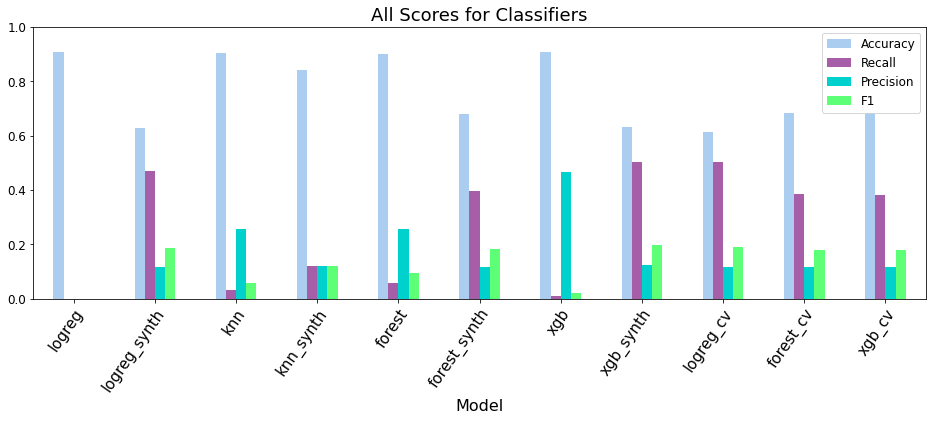

In [34]:
#save score_df for next notebook
%store score_df

#show scores
print(score_df)

colors={'Accuracy':'#ABCDEF', 'Recall':'#A55EA7', 'Precision':'#00D1CC', 'F1':'#5CFF75'}

#visualize scores
score_df.set_index('Name').plot(kind='bar', figsize=(16,5), color=colors,
                                legend=True, ylim=(0,1), fontsize=12)

plt.title('All Scores for Classifiers', fontsize=18)
plt.xlabel('Model', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(rotation= 55, ha='right', rotation_mode='anchor', fontsize=15)

This shows us the 4 primary scoring metrics for each model, in the order that they were created. There is a lot of data on this, though, and we have established that the Accuracy score is an untrustworthy one in this scenario. Let's look at **only** the F1 scores, our most significant metric in this anlysis.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'xgb_synth'),
  Text(1, 0, 'logreg_cv'),
  Text(2, 0, 'logreg_synth'),
  Text(3, 0, 'forest_synth'),
  Text(4, 0, 'forest_cv'),
  Text(5, 0, 'xgb_cv'),
  Text(6, 0, 'knn_synth'),
  Text(7, 0, 'forest'),
  Text(8, 0, 'knn'),
  Text(9, 0, 'xgb'),
  Text(10, 0, 'logreg')])

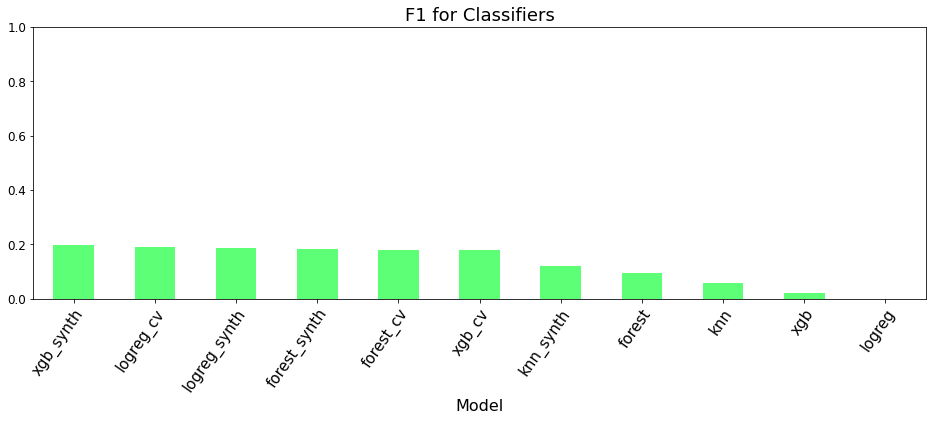

In [40]:
#visualize f1 scores from highest to lowest

score_df.sort_values(by=['F1'], ascending=False).set_index('Name')['F1'].plot(kind='bar', figsize=(16,5),
                                legend=False, ylim=(0,1), fontsize=12, color='#5CFF75')

plt.title('F1 for Classifiers', fontsize=18)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation= 55, ha='right', rotation_mode='anchor', fontsize=15)

### How to interpret this information
These scores to not look good. With an ideal score being as close to 1 as possible, none even come close.

Even after hyperparameter tuning, none of the models increased their performance to any notable degree. This points to a larger issue: our data. Fortunately, when cleaning and analyzing our data we created two other target variables: 'Arrested' and 'Legal Action Taken'. These targets may prove beneficial to our models, since they suffer less from class imbalance than our current target ('Physical Arrest') does.

In [37]:
#show other target classes:

sample_df = pd.read_csv('data/cleaned_df.csv')
print(sample_df['Physical_Arrest'].value_counts())
print('')
print(sample_df['Arrested'].value_counts())
print('')
print(sample_df['Legal_Action_Taken'].value_counts())

0    47418
1     4729
Name: Physical_Arrest, dtype: int64

0    39321
1    12826
Name: Arrested, dtype: int64

1    30082
0    22065
Name: Legal_Action_Taken, dtype: int64


The following notebook will use appropriate feature selection and machine learning pipelines to see how our classifiers can be improved and altered to yield more meaningful results:

### [Feature and Target Selection](./nb_3-new_features_and_targets.ipynb)